# Debiasing BERT on Sentiment Analysis across Gender

This notebook works through debiasing a BERT model that is biased across gender on a sentiment analysis task. The notebook proceeds as follows:

1. Train a BERT model (blackbox model) on the [SemEval 2018](https://competitions.codalab.org/competitions/17751) sentiment analysis task.
2. Evaluate the blackbox model's bias across gender using the [EEC benchmark](https://saifmohammad.com/WebPages/Biases-SA.html). 
3. Learn a distributed alignment using DAS between the blackbox model and gender, using counterfactuals from the EEC benchmark dataset.
4. Use the learned alignment to intervene on the blackbox model during inference time with a static "gender" representation vector (e.g. average of male representation, average of female representation, average of both, or null vector), and evaluate this debiased model on: (a) the original SemEval task, and (b) the new model's bias on EEC.

Using distributed alignment search, we're able to intervene on a pre-trained BERT model in order to achieve a debiased model with similar accuracy!

In [1]:
import torch
import random
import copy
import itertools
import numpy as np
import utils
from trainer import BERTLIMTrainer

from sklearn.metrics import classification_report
from LIM_bert import LIMBERTClassifier
import dataset_nli

from transformers import BertModel, BertTokenizer
utils.fix_random_seeds()

In [ ]:
"""
for training IIT:
 - create CLIP model
 - run its vision model to get image embedding (can even do this statically)
 - run LIMClip to get text embedding
 - use CLIP text/image projections (stored in CLIP model) to project to same space
 - compute contrastive loss (varied by intervention??)
"""

## Train Blackbox Model

In this section, we train fine-tune a BERT model on the [SemEval 2018](https://competitions.codalab.org/competitions/17751) task. The task is to predict the joy sentiment of tweets from Twitter, provided human-generated labels in [0, 1]. The SemEval task also consists of detecting anger, sadness, and fear aspects. 

The original benchmark compares models using the pearson correlation coefficient. A coefficient above 68% places us within the top 20 models evaluated on the benchmark.

In [2]:
import os

BASE = '../../local/SemEval2018-Task1-all-data/English/'
task = 'EI'
task_type = 'reg'
path = os.path.join(BASE, f'{task}-{task_type}')
os.listdir(path)

['development', 'test-gold', 'training']

In [3]:
import pandas as pd

def load_data_ei(path):
    train_df = pd.read_csv(os.path.join(path, 'training', f'EI-{task_type}-En-joy-train.txt'), delimiter='\t')
    eval_df = pd.read_csv(os.path.join(path, 'development', f'2018-EI-{task_type}-En-joy-dev.txt'), delimiter='\t')
    test_df = pd.read_csv(os.path.join(path, 'test-gold', f'2018-EI-{task_type}-En-joy-test-gold.txt'), delimiter='\t')

    if 'Intensity Class' in train_df.columns:
        classes = train_df['Intensity Class'].unique()
        class_to_label = dict(zip(classes, range(len(classes))))
        train_df['labels'] = train_df['Intensity Class'].map(class_to_label)
        eval_df['labels'] = eval_df['Intensity Class'].map(class_to_label)
        test_df['labels'] = test_df['Intensity Class'].map(class_to_label)
    else:
        train_df['labels'] = train_df['Intensity Score'].copy()
        eval_df['labels'] = eval_df['Intensity Score'].copy()
        test_df['labels'] = test_df['Intensity Score'].copy()

    rename = {
        'Tweet': 'text'
    }
    train_df = train_df[['Tweet', 'labels']].rename(columns=rename)
    eval_df = eval_df[['Tweet', 'labels']].rename(columns=rename)
    test_df = test_df[['Tweet', 'labels']].rename(columns=rename)

    return train_df, eval_df, test_df

def load_data_ec(path):
    train_df = pd.read_csv(os.path.join(path, '2018-E-c-En-train.txt'), delimiter='\t')
    eval_df = pd.read_csv(os.path.join(path, '2018-E-c-En-dev.txt'), delimiter='\t')
    test_df = pd.read_csv(os.path.join(path, '2018-E-c-En-test-gold.txt'), delimiter='\t')

    
    train_df['labels'] = train_df.apply(lambda r: r.iloc[2:].tolist(), axis=1)
    eval_df['labels'] = eval_df.apply(lambda r: r.iloc[2:].tolist(), axis=1)
    test_df['labels'] = test_df.apply(lambda r: r.iloc[2:].tolist(), axis=1)

    rename = {
        'Tweet': 'text'
    }
    train_df = train_df[['Tweet', 'labels']].rename(columns=rename)
    eval_df = eval_df[['Tweet', 'labels']].rename(columns=rename)
    test_df = test_df[['Tweet', 'labels']].rename(columns=rename)

    return train_df, eval_df, test_df

train_df, eval_df, test_df = load_data_ei(path)
train_df.shape, eval_df.shape, test_df.shape

((1616, 2), (290, 2), (1105, 2))

In [4]:
def get_semeval_dataset(df, tokenizer_name, data_size):
    bert_tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
    
    def encoding(X):
        # if X[0][-1] != ".":
        #     input = [". ".join(X)]
        # else:
        #     input = [" ".join(X)]
        input = [X]
        data = bert_tokenizer.batch_encode_plus(
            input,
            max_length=128,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        indices = torch.tensor(data['input_ids'])
        mask = torch.tensor(data['attention_mask'])
        return (indices, mask)
    
    data = []
    for i, row in df.iterrows():
        if i == data_size:
            break
        x_base, x_mask = encoding(row['text'])
        y_base = row['labels']
        data.append((x_base, x_mask, y_base))
    
    base, base_mask, y = zip(*data)
    X_base = (base, base_mask) 
    y_base = torch.tensor(y)

    return X_base, y_base

In [5]:
from ii_benchmark import IIBenchmarkMoNli

VAR = 0

num_layers = 12
hidden_dim = 768
data_size = train_df.shape[0]
test_data_size = test_df.shape[0] - 1 # size is unfortunately 1 mod 8, and I'm too lazy to edit prediction code
device = 'cuda:0'
seed = 42

iit_layer = 10
hidden_dim_per_concept = 256

intervention_ids_to_coords = {
    VAR: [{"layer":iit_layer, "start":0, "end":hidden_dim_per_concept}]
}

benchmark = IIBenchmarkMoNli(
    variable_names=['GEN'],
    data_parameters={
        'train_size': data_size, 'test_size': test_data_size
    },
    model_parameters={
        'weights_name': 'bert-base-uncased',
        'max_length': 128,
        'n_classes': 1,
        'hidden_dim': 768,
        'target_layers' : [iit_layer],
        'target_dims':{
            "start" : 0,
            "end" : 786,
        },
        'debug':False, 
        'device': device,
        'static_search': False,
        'nested_disentangle_inplace': False
    },
    training_parameters={
        'warm_start': False, 'max_iter': 200, 'batch_size': 8, 'n_iter_no_change': 10, 
        'shuffle_train': False, 'eta': 2e-5, 'device': device, 'save_checkpoint_per_epoch': True
    },
    seed=seed
)

In [6]:
LIM_bert = benchmark.create_model().to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
LIM_trainer = benchmark.create_classifier(LIM_bert)
LIM_trainer.model.set_analysis_mode(False)

In [8]:
X_semeval_train, y_semeval_train = get_semeval_dataset(train_df, 'bert-base-uncased', data_size)

In [9]:
# _ = LIM_trainer.fit(
#     X_semeval_train,
#     y_semeval_train
# )

Stopping after epoch 58. Training loss did not improve more than tol=1e-05. Final error is 0.9914800344849937.

In [11]:
# torch.save(LIM_trainer.model.state_dict(), 'semeval-blackbox-layer-10.pt')

In [8]:
import torch

model_name = 'saved_models/blackbox-45-42.bin'

LIM_trainer.model.load_state_dict(state_dict=torch.load(model_name))

<All keys matched successfully>

In [9]:
from scipy.stats import pearsonr

X_semeval_test, y_semeval_test = get_semeval_dataset(test_df, 'bert-base-uncased', test_df.shape[0] - 1)
predictions = LIM_trainer.predict(
    X_semeval_test
)

pearsonr(predictions.cpu().numpy(), y_semeval_test.numpy())

PearsonRResult(statistic=0.6917114316441573, pvalue=5.803894323100251e-158)

## Evaluate Bias on EEC

This section replicates the bias evaluation conducted in [Kiritchenko and Mohammad, 2018](https://saifmohammad.com/WebPages/Biases-SA.html). The Equity Evaluation Corpus (EEC) consists of pairs of sentences where the key gender noun is toggled between a stereotypically female and a stereotypically male instance (e.g. "he feels happy" vs. "she feels happy", "the conversation with my son was shocking" vs. "the conversation with my daughter was shocking"). 

To detect bias, the authors compare the model's predictions across the 429 pairs generated in the EEC dataset. Notably, the EEC dataset *does not have labels*, but instead evaluates equity by comparing the model's prediction on an input to its prediction on the corresponding (counterfactual) input where the gender is flipped. We can compare the following two measures in order to determine the bias in our model:
1. Rate at which the model predicts one gender over another (%M > F and %F > M). 
2. Difference between the average model predictions (M - F and F - M), with signficance measured by a t-test. 

In [5]:
EEC_PATH = 'eec_blackbox.csv'

class EEC_Dataset:
    def __init__(self, embed_func, emotions=['joy']) -> None:
        self.eec_df = pd.read_csv(EEC_PATH)
        self.embed_func = embed_func
        self.emotions = emotions

        self.eec_df = self.eec_df[(self.eec_df['Emotion'].isin(emotions)) | (self.eec_df['Emotion'].isna())]

        self._setup()

    def _setup(self):
        self.templates = self.eec_df['Template'].unique()
        self.emotion_situation_words = self.eec_df[
            self.eec_df['Template'].apply(lambda t: '<emotional situation word>' in t)
        ]['Emotion word'].unique()
        self.emotion_words = self.eec_df[
            self.eec_df['Template'].apply(lambda t: '<emotion word>' in t)
        ]['Emotion word'].unique()

        nouns = self.eec_df['Person'].unique()
        pro_nouns = [p for p in nouns if p[0].islower()]
        offset = (len(pro_nouns) - 2) // 2
        pronoun_matching = {
            pro_nouns[i]: pro_nouns[i + offset] for i in range(offset)
        }
        pronoun_matching.update({ 'him': 'her' })
        self.pronoun_matching = pronoun_matching

        proper_nouns = {
            'male': [p for p in self.eec_df[self.eec_df['Gender'] == 'male']['Person'].unique() if p[0].isupper()],
            'female': [p for p in self.eec_df[self.eec_df['Gender'] == 'female']['Person'].unique() if p[0].isupper()]
        }
        self.proper_nouns = proper_nouns

    def _get_pairs_dataset(self):
        pairs_data = []
        columns = ['Sentence_M', 'Sentence_F', 'Template', 'Emotion', 'Emotion Word', 'Person']
        for template in self.templates:
            if '<emotional situation word>' in template:
                emotion_list = self.emotion_situation_words
            elif '<emotion word>' in template:
                emotion_list = self.emotion_words
            else:
                emotion_list = [None]

            for w in emotion_list:
                if w is None:
                    state_df = self.eec_df[(self.eec_df['Template'] == template)]
                else:
                    state_df = self.eec_df[(self.eec_df['Emotion word'] == w) & (self.eec_df['Template'] == template)]

                for base_pronoun, flip_pronoun in self.pronoun_matching.items():
                    if (base_pronoun == 'he' and '<person subject>' not in template) or \
                        (base_pronoun == 'him' and '<person object>' not in template):
                        continue
                    
                    # ensure that we only have one of each noun
                    assert(state_df[state_df['Person'] == base_pronoun].shape[0] == 1)

                    pairs_data.append([
                        state_df[state_df['Person'] == base_pronoun].iloc[0]['Sentence'],
                        state_df[state_df['Person'] == flip_pronoun].iloc[0]['Sentence'],
                        template,
                        state_df[state_df['Person'] == flip_pronoun].iloc[0]['Emotion'],
                        w, 
                        'pronoun'
                    ])

                pairs_data.append([
                    [
                        state_df[state_df['Person'] == male_proper_noun].iloc[0]['Sentence']
                        for male_proper_noun in self.proper_nouns['male']
                    ],
                    [
                        state_df[state_df['Person'] == female_proper_noun].iloc[0]['Sentence']
                        for female_proper_noun in self.proper_nouns['female']
                    ],
                    template,
                    state_df.iloc[0]['Emotion'],
                    w,
                    'proper noun'
                ])

        pairs_df = pd.DataFrame(pairs_data, columns=columns)
        return pairs_df

    def get_dataset(self, variable):
        pairs_df = self._get_pairs_dataset()
        pronoun_data = []
        proper_noun_data = []
        for i, row in pairs_df.iterrows():
            if row['Person'] == 'pronoun':
                if variable == 'male':
                    base_x, base_mask = self.embed_func(row['Sentence_M'])
                else:
                    base_x, base_mask = self.embed_func(row['Sentence_F'])
                pronoun_data.append((base_x, base_mask))
            else:
                if variable == 'male':
                    embedded = [self.embed_func(s) for s in row['Sentence_M']]
                else:
                    embedded = [self.embed_func(s) for s in row['Sentence_F']]
                base_x, base_mask = zip(*embedded)
                proper_noun_data.append((base_x, base_mask))
        
        base_pronoun, base_mask_pronoun = zip(*pronoun_data)
        self.base_pronoun = base_pronoun
        self.base_mask_pronoun = base_mask_pronoun

        base_proper_noun, base_mask_proper_noun = zip(*proper_noun_data)
        self.base_proper_noun = base_proper_noun
        self.base_mask_proper_noun = base_mask_proper_noun
        return (self.base_pronoun, self.base_mask_pronoun), (self.base_proper_noun, self.base_mask_proper_noun)

In [6]:
def get_EEC_dataset(tokenizer_name):
    bert_tokenizer = BertTokenizer.from_pretrained(tokenizer_name)

    def encoding(X):
        input = [X]
        data = bert_tokenizer.batch_encode_plus(
                input,
                max_length=128,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                return_attention_mask=True)
        indices = torch.tensor(data['input_ids'])
        mask = torch.tensor(data['attention_mask'])
        return (indices, mask)
    
    eec_dataset = EEC_Dataset(embed_func=encoding)

    pronoun_dataset_m, proper_noun_dataset_m = eec_dataset.get_dataset('male')
    pronoun_dataset_f, proper_noun_dataset_f = eec_dataset.get_dataset('female')

    return pronoun_dataset_m, proper_noun_dataset_m, pronoun_dataset_f, proper_noun_dataset_f

In [7]:
def evaluate_on_EEC(LIM_trainer, dataset):
    pronoun_dataset_m, proper_noun_dataset_m, pronoun_dataset_f, proper_noun_dataset_f = dataset

    predictions_m = LIM_trainer.predict(pronoun_dataset_m)
    predictions_f = LIM_trainer.predict(pronoun_dataset_f)

    for x_m in zip(*proper_noun_dataset_m):
        predictions_m = torch.cat((
            predictions_m,
            LIM_trainer.predict(x_m).mean().unsqueeze(0)
        ))
    
    for x_f in zip(*proper_noun_dataset_f):
        predictions_f = torch.cat((
            predictions_f,
            LIM_trainer.predict(x_f).mean().unsqueeze(0)
        ))
    
    return predictions_m, predictions_f

In [39]:
eec_dataset = get_EEC_dataset('bert-base-uncased')
predictions_m, predictions_f = evaluate_on_EEC(LIM_trainer, eec_dataset)

predictions_m = predictions_m.detach().cpu().numpy()
predictions_f = predictions_f.detach().cpu().numpy()

In [44]:
print(predictions_m.mean(), predictions_f.mean())
print(predictions_m.mean() - predictions_f.mean())

0.5847737 0.54655355
0.038220167


In [41]:
print((predictions_m > predictions_f).sum() / len(predictions_m))

0.9044289044289044


In [42]:
from scipy.stats import ttest_ind

ttest_ind(predictions_m, predictions_f)

Ttest_indResult(statistic=5.002500184837189, pvalue=6.868004333009701e-07)

The code below saves the blackbox model predictions as static labels for the interchange intervention training in the next section.

In [13]:
def get_EEC_sentence_inputs(tokenizer_name):
    bert_tokenizer = BertTokenizer.from_pretrained(tokenizer_name)

    def encoding(X):
        input = [X]
        data = bert_tokenizer.batch_encode_plus(
                input,
                max_length=128,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                return_attention_mask=True)
        indices = torch.tensor(data['input_ids'])
        mask = torch.tensor(data['attention_mask'])
        return (indices, mask)
    
    eec_df = pd.read_csv(EEC_PATH)

    data = []
    for sentence in eec_df['Sentence'].values:
        data.append(encoding(sentence))
    
    inputs, masks = zip(*data)

    return inputs, masks

In [14]:
# X_eec = get_EEC_sentence_inputs('bert-base-uncased')

# blackbox_preds = LIM_trainer.predict(X_eec) 

In [15]:
# EEC_PATH = 'eec_blackbox.csv'

# eec_df = pd.read_csv(EEC_PATH)

# eec_df['Prediction'] = blackbox_preds.detach().cpu().numpy()

# eec_df.to_csv(EEC_PATH[:-4] + '-layer-10-iter-45-seed-42.csv')

## Learning Distributed Alignments on EEC

In this section, we learn an alignment between the sensitive attribute in our causal graph (gender) and the biased blackbox model. We use the EEC dataset to generate our counterfactuals, and we use *the original model's output* as our target behavior. 

Note that in this section, we are not trying to debias our model yet. In fact, we are trying to completely replicate the blackbox model's behavior, including its initial bias. But the key idea is that we hope to do so in an interpretable, *intervenable* way that will allow us to later debias the very same model.

Small note: when using analysis mode set to `True`, the code below runs Distributed Alignment Search (DAS). When analysis mode is set to `False`, the code trains a Causal Proxy Model (CPM). 

In [17]:
import pandas as pd
import numpy as np
import itertools
import random
from functools import reduce
from sklearn.model_selection import train_test_split

# NOTE: this path should correspond to the saved outputs of the model we want to debias
EEC_PATH = 'eec_blackbox-layer-10-iter-45-seed-42.csv' 

CONTROLS = [] # ['Emotion word', 'Template'] # ['Emotion word']
SEED = 42
VAR = 0
TRAIN_SIZE = 0.8

class IIT_EEC_Dataset:
    def __init__(self, embed_func, split, size, emotion='joy'):
        self.embed_func = embed_func
        self.split = split
        self.size = size
        eec_df = pd.read_csv(EEC_PATH)
        eec_df = eec_df[eec_df['Emotion'] == emotion].reset_index(drop=True)
        self.train_df, self.test_df = train_test_split(eec_df, train_size=TRAIN_SIZE, shuffle=True)
        self.eec_df = self.train_df if self.split == 'train' else self.test_df
        self.variables = list(self.eec_df['Gender'].unique())
        self.controls = CONTROLS
        assert len(self.variables) == 2
        assert self.size % 2 == 0

    def flip(self, v):
        if v == self.variables[0]:
            return self.variables[1]
        else:
            return self.variables[0]

    def get_intervention(self, base, source):
        return VAR

    def create_dataset_by_variable_states(self):
        data = {}
        variables = self.controls + ['Gender']
        control_values = [list(self.eec_df[v].unique()) for v in variables]
        num_classes = reduce(lambda a, b: a * b, [len(l) for l in control_values])
        s = self.size // num_classes
        for variable_state in itertools.product(*control_values):
            state_data = self.eec_df[
                reduce(
                    lambda a, b: a & b,
                    [self.eec_df[variables[i]] == variable_state[i] for i in range(len(variables))]
                )
            ]

            # for now, simply ignore missing data
            if state_data.shape[0] == 0:
                continue
            
            state_data = state_data.sample(s, random_state=SEED)

            data[variable_state] = []
            for i, r in state_data.iterrows():
                base_x, base_mask = self.embed_func(r['Sentence'])
                base_label = r['Prediction']
                data[variable_state].append((base_x, base_mask, base_label))
        return data

    def create_dataset(self, debiased=False, shuffle=True):
        data = []
        variables = self.controls + ['Gender']
        control_values = [list(self.eec_df[v].unique()) for v in variables]
        num_classes = reduce(lambda a, b: a * b, [len(l) for l in control_values])
        s = self.size // num_classes # number of pairs per variable state
        for base_state in itertools.product(*control_values):
            base_df = self.eec_df[
                reduce(
                    lambda a, b: a & b,
                    [self.eec_df[variables[i]] == base_state[i] for i in range(len(variables))]
                )
            ].copy().reset_index(drop=True)

            # keep all controls the same, but flip gender value
            source_state = list(base_state)[:-1] + [self.flip(base_state[-1])]
            source_df = self.eec_df[
                reduce(
                    lambda a, b: a & b,
                    [self.eec_df[variables[i]] == source_state[i] for i in range(len(variables))]
                )
            ].copy().reset_index(drop=True)

            # for now, sample up to s pairs per variable state
            k = min(s, base_df.shape[0] * source_df.shape[0])

            pair_indices = random.sample(
                list(itertools.product(base_df.index, source_df.index)), k=k
            )

            for base_i, source_i in pair_indices:
                base, source = base_df.iloc[base_i], source_df.iloc[source_i]
                base_x, base_mask = self.embed_func(base['Sentence'])
                source_x, source_mask = self.embed_func(source['Sentence'])
                base_label = base['Prediction']
                intervention = self.get_intervention(base, source)
                # assuming that gender is a causal variable in our graph
                IIT_label = source['Prediction']

                # if debiased, we'd like the label to be the mean of the base & source inputs
                if debiased:
                    base_label = IIT_label = (base_label + IIT_label) / 2.0

                data.append((base_x, base_mask, base_label, source_x, source_mask, IIT_label, intervention))

        if shuffle:
            data.sort(key=lambda x: x[-1])
            random.shuffle(data)
        
        base, base_mask, y, source, source_mask, IIT_y, interventions = zip(*data)
        self.base = base
        self.base_mask = base_mask
        self.source = source
        self.source_mask = source_mask
        self.y = np.array(y)
        self.IIT_y = np.array(IIT_y)
        self.interventions = np.array(interventions)
        return (self.base, self.base_mask), self.y, [(self.source,self.source_mask)], self.IIT_y, self.interventions

In [18]:
def get_IIT_EEC_dataset(
    data_size,
    tokenizer_name,
    split="train",
    debiased=False,
    shuffle=True
):
    bert_tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
    
    def encoding(X):
        input = [X]
        data = bert_tokenizer.batch_encode_plus(
                input,
                max_length=128,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                return_attention_mask=True)
        indices = torch.tensor(data['input_ids'])
        mask = torch.tensor(data['attention_mask'])
        return (indices, mask)
    
    dataset = IIT_EEC_Dataset(
        embed_func=encoding,
        split=split,
        size=data_size
    )
    
    X_base, y_base, X_sources,  y_IIT, interventions = dataset.create_dataset(debiased=debiased, shuffle=shuffle)
    y_base = torch.tensor(y_base)
    y_IIT = torch.tensor(y_IIT)
    interventions = torch.tensor(interventions)
    return X_base, y_base, X_sources,  y_IIT, interventions

In [11]:
from ii_benchmark import IIBenchmarkMoNli

VAR = 0

num_layers = 12
hidden_dim = 768
data_size = 4096
test_data_size = 256
device = 'cuda:0'
seed = 42

iit_layer = 10 # 8
hidden_dim_per_concept = 256

intervention_ids_to_coords = {
    VAR: [{"layer":iit_layer, "start":0, "end":hidden_dim_per_concept}]
}

benchmark = IIBenchmarkMoNli(
    variable_names=['GEN'],
    data_parameters={
        'train_size': data_size, 'test_size': test_data_size
    },
    model_parameters={
        'weights_name': 'bert-base-uncased',
        'max_length': 128,
        'n_classes': 1,
        'hidden_dim': 768,
        'target_layers' : [iit_layer],
        'target_dims':{
            "start" : 0,
            "end" : 786,
        },
        'debug':False, 
        'device': device,
        'static_search': False,
        'nested_disentangle_inplace': False,
        'learned_intervention_size': hidden_dim_per_concept
    },
    training_parameters={
        'warm_start': False, 'max_iter': 10, 
        'batch_size': 4, #8, 
        'n_iter_no_change': 10, 
        'shuffle_train': False, 
        'eta': 1e-5, # 0.0005, 
        'device': device        
    },
    seed=seed
)

In [12]:
LIM_bert = benchmark.create_model().to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
LIM_trainer = benchmark.create_classifier(LIM_bert)
# LIM_trainer.model.set_analysis_mode(False)
# LIM_trainer.model.set_analysis_mode(True) # try to learn alignment

In [14]:
LIM_trainer.model.set_learn_intervention_vector(False)

In [15]:
import torch

model_name = 'saved_models/blackbox-45-42.bin'
# model_name = 'dist-eec-layer-10.pt'

LIM_trainer.model.load_state_dict(state_dict=torch.load(model_name))

<All keys matched successfully>

In [9]:
LIM_trainer.model.set_learn_intervention_vector(True)

Toggle the mode below to switch from DAS (`True`) to CPM (`False`).

In [22]:
# LIM_trainer.model.set_analysis_mode(True)

In [27]:
from scipy.stats import pearsonr

X_semeval_test, y_semeval_test = get_semeval_dataset(test_df, 'bert-base-uncased', test_df.shape[0] - 1)
predictions = LIM_trainer.predict(
    X_semeval_test
)

pearsonr(predictions.cpu().numpy(), y_semeval_test.numpy())

PearsonRResult(statistic=0.6664184538330994, pvalue=1.106228422322491e-142)

In [10]:
train_datasetIIT = get_IIT_EEC_dataset(
    data_size=data_size, 
    split="train",
    tokenizer_name='bert-base-uncased'
)
X_base_train, y_base_train = train_datasetIIT[0:2]
iit_data = tuple(train_datasetIIT[2:])

In [ ]:
_ = LIM_trainer.fit(
    X_base_train, 
    y_base_train, 
    iit_data=iit_data,
    intervention_ids_to_coords=intervention_ids_to_coords
)

Learn intervention vector to debias model

In [10]:
train_datasetIIT = get_IIT_EEC_dataset(
    data_size=data_size, 
    split="train",
    tokenizer_name='bert-base-uncased'
    # debiased=True
)
X_base_train, y_base_train = train_datasetIIT[0:2]
iit_data = tuple(train_datasetIIT[2:])

In [28]:
# when learning intervention vector
_ = LIM_trainer.fit(
    X_base_train, 
    y_base_train, 
    iit_data=iit_data,
    intervention_ids_to_coords=intervention_ids_to_coords
)

Epoch 1:   0%|          | 0/508 [00:00<?, ?it/s]c:\Users\amirz\.conda\envs\interchange\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1:   0%|          | 1/508 [01:22<11:40:59, 82.96s/it, loss=0.00435, epoch_loss=0.00435]c:\Users\amirz\.conda\envs\interchange\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1: 100%|█████████▉| 507/508 [02:09<00:00, 10.04it/s, loss=0.0158, epoch_loss=5.72]     c:\Users\amirz\.conda\envs\interchange\lib\sit

In [14]:
# torch.save(LIM_trainer.model.state_dict(), 'das-eec-layer-10-learned-intervention.pt')

In [18]:
import torch

model_name = 'dist-eec-no-controls.pt'

LIM_trainer.model.load_state_dict(state_dict=torch.load(model_name))
LIM_trainer.model.set_analysis_mode(True)

In [15]:
X_sources,  y_IIT, interventions = iit_data

# train data eval
base_preds_train = LIM_trainer.predict(
    X_base_train
)
IIT_preds_train = LIM_trainer.iit_predict(
    X_base_train, X_sources, 
    interventions, 
    intervention_ids_to_coords
)

In [16]:
test_datasetIIT = get_IIT_EEC_dataset(
    data_size=test_data_size, 
    split="test",
    tokenizer_name='bert-base-uncased'
)
X_base_test, y_base_test, X_sources_test, y_IIT_test, interventions_test = test_datasetIIT

In [17]:
# train data eval
base_preds_test = LIM_trainer.predict(
    X_base_test
)
IIT_preds_test = LIM_trainer.iit_predict(
    X_base_test, X_sources_test, 
    interventions_test, 
    intervention_ids_to_coords
)

In [22]:
# test on held-out semeval test set (original task)
X_semeval_test, y_semeval_test = get_semeval_dataset(test_df, 'bert-base-uncased', test_df.shape[0] - 1)
semeval_preds_test = LIM_trainer.predict(
    X_semeval_test
)

### Base Task Metrics

How well does the model do at replicating the blackbox model's behavior on the EEC dataset? (**only applies to CPM**)

In [23]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

mse = mean_squared_error(
    y_pred=base_preds_train.squeeze().detach().cpu().numpy(), 
    y_true=y_base_train.squeeze().detach().cpu().numpy()
)
corr = pearsonr(
    base_preds_train.squeeze().detach().cpu().numpy(), 
    y_base_train.squeeze().detach().cpu().numpy()
)

print('Train')
print(mse)
print(corr)

Train
0.004512094702692895
PearsonRResult(statistic=0.7993635034694295, pvalue=0.0)


In [24]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

mse = mean_squared_error(
    y_pred=base_preds_test.squeeze().detach().cpu().numpy(), 
    y_true=y_base_test.squeeze().detach().cpu().numpy()
)
corr = pearsonr(
    base_preds_test.squeeze().detach().cpu().numpy(), 
    y_base_test.squeeze().detach().cpu().numpy()
)

print('Test')
print(mse)
print(corr)


Test
0.0048092496414756224
PearsonRResult(statistic=0.7949749456576142, pvalue=2.0874391457961243e-16)


### IIT Objective Metrics

**Key metric**: does our alignment achieve a strong interchange intervention accuracy?

In [32]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

mse = mean_squared_error(
    y_pred=IIT_preds_train.squeeze().detach().cpu().numpy(), 
    y_true=y_IIT.squeeze().detach().cpu().numpy()
)
corr = pearsonr(
    IIT_preds_train.squeeze().detach().cpu().numpy(), 
    y_IIT.squeeze().detach().cpu().numpy()
)

print('Train')
print(mse)
print(corr)


Train
0.0020499918859300348
PearsonRResult(statistic=0.9133175547595499, pvalue=0.0)


In [33]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

mse = mean_squared_error(
    y_pred=IIT_preds_test.squeeze().detach().cpu().numpy(), 
    y_true=y_IIT_test.squeeze().detach().cpu().numpy()
)
corr = pearsonr(
    IIT_preds_test.squeeze().detach().cpu().numpy(), 
    y_IIT_test.squeeze().detach().cpu().numpy()
)

print('Test')
print(mse)
print(corr)


Test
0.002179943798611736
PearsonRResult(statistic=0.8765886207244193, pvalue=1.1906229533680072e-82)


### SemEval Test Set

How well does the model do at replicating the blackbox model's behavior on the SemEval dataset? (**only applies to CPM**)

In [25]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

mse = mean_squared_error(
    y_pred=semeval_preds_test.squeeze().detach().cpu().numpy(), 
    y_true=y_semeval_test.squeeze().detach().cpu().numpy()
)
corr = pearsonr(
    semeval_preds_test.squeeze().detach().cpu().numpy(), 
    y_semeval_test.squeeze().detach().cpu().numpy()
)

print('Test')
print(mse)
print(corr)

Test
0.029105332
PearsonRResult(statistic=0.6664184538330994, pvalue=1.106228422322491e-142)


## Debiasing

In this section, we take our blackbox model along with our learned alignment, and try to create a debiased version of our model. We do this by intervening on the model's internal representation of gender (as indicated by our alignment) during inference time. Some intervention options include the following:
- **Male-Only**: intervene with a static "male" vector, computed by averaging over the activations of gender when running our model on EEC sentences with a male noun.
- **Female-Only**: similarly, intervene with a static "female" vector.
- **Null-Out**: intervene with a static zero vector.
- **Average**: intervene with a static vector that averages the male and female activations. 

In [16]:
def get_IIT_EEC_dataset_by_variable_state(
    data_size,
    tokenizer_name,
    split="train"
):
    bert_tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
    
    def encoding(X):
        input = [X]
        data = bert_tokenizer.batch_encode_plus(
                input,
                max_length=128,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                return_attention_mask=True)
        indices = torch.tensor(data['input_ids'])
        mask = torch.tensor(data['attention_mask'])
        return (indices, mask)
    
    dataset = IIT_EEC_Dataset(
        embed_func=encoding,
        split=split,
        size=data_size)
    
    data = dataset.create_dataset_by_variable_states()

    output = {}
    for key in data:
        base, base_mask, y_base = zip(*data[key])
        X_base = (base, base_mask)
        y_base = torch.tensor(y_base)
        output[key] = (X_base, y_base)

    return output

In [9]:
def get_activations_by_variable_state(data_size, gets, tokenizer_name='bert-base-uncased', split='train', batch_size=8):
    dataset = get_IIT_EEC_dataset_by_variable_state(data_size, tokenizer_name, split)
    output = {}
    for key in dataset:
        X_base, y_base = dataset[key]
        inputs, masks = X_base
        inputs, masks = torch.stack(inputs).squeeze(), torch.stack(masks).squeeze()
        # print(inputs.shape)
        activations = []
        with torch.no_grad():
            for b in range(0, inputs.size(0), batch_size):
                X_batch = (
                    inputs[b:b + batch_size].to(LIM_trainer.device), 
                    masks[b:b + batch_size].to(LIM_trainer.device)
                )
                # for now (for whatever reason) cut off batch sizes that are too small
                if X_batch[0].size(0) < batch_size:
                    break
                activations_batch, _ = LIM_trainer.model.retrieve_activations(X_batch, gets[0], None)
                activations.append(activations_batch)
        output[key] = torch.cat(activations, dim=0).mean(dim=0)
    return output

In [10]:
def get_intervention_logits_by_variable_state(v, data, activations, gets, batch_size=8):
    output = {}
    for key in data:
        output[key] = []
        X_base, y_base = data[key]
        inputs, masks = X_base
        inputs, masks = torch.stack(inputs).squeeze(), torch.stack(masks).squeeze()

        sets = copy.deepcopy(gets)
        # keep control variables, set sensitive variable
        new_key = tuple(list(key)[:-1] + [v])
        sets[0]['intervention'] = activations[new_key].repeat((batch_size, 1))

        logits = []
        with torch.no_grad():
            for b in range(0, inputs.size(0), batch_size):
                X_batch = (
                    inputs[b:b + batch_size].to(LIM_trainer.device), 
                    masks[b:b + batch_size].to(LIM_trainer.device)
                )
                # for now cut off batch sizes that are too small
                # (can also re-evaluate sets for each batch)
                if X_batch[0].size(0) < batch_size:
                    break
                
                _, logits_batch = LIM_trainer.model.retrieve_activations(X_batch, gets[0], sets)
                logits.append(logits_batch)
        output[key] = {'intervention': torch.cat(logits, dim=0), 'base': y_base.unsqueeze(0)}
    return output

In [11]:
def evaluate_on_EEC_with_intervention(LIM_trainer, dataset, gets, intervention):
    pronoun_dataset_m, proper_noun_dataset_m, pronoun_dataset_f, proper_noun_dataset_f = dataset

    predictions_m = LIM_trainer.predict_with_intervention(pronoun_dataset_m, gets, intervention)
    predictions_f = LIM_trainer.predict_with_intervention(pronoun_dataset_f, gets, intervention)

    for x_m in zip(*proper_noun_dataset_m):
        predictions_m = torch.cat((
            predictions_m,
            LIM_trainer.predict_with_intervention(x_m, gets, intervention).mean().unsqueeze(0)
        ))
    
    for x_f in zip(*proper_noun_dataset_f):
        predictions_f = torch.cat((
            predictions_f,
            LIM_trainer.predict_with_intervention(x_f, gets, intervention).mean().unsqueeze(0)
        ))
    
    return predictions_m, predictions_f

In [18]:
VAR = 0

intervention_ids_to_coords = {
    VAR: [{"layer":iit_layer, "start":0, "end":hidden_dim_per_concept}]
}

data_size = 512
gets = intervention_ids_to_coords[0]

In [19]:
_ = LIM_trainer.model.eval()

In [ ]:
data_size = 1000
activations = get_activations_by_variable_state(data_size, gets)

In [43]:
torch.nn.functional.cosine_similarity(activations[('female',)], activations[('male',)], dim=0)

tensor(0.9920, device='cuda:0')

### Male-Only Intervention

In [44]:
eec_dataset = get_EEC_dataset('bert-base-uncased')

predictions_m, predictions_f = evaluate_on_EEC_with_intervention(LIM_trainer, eec_dataset, gets, activations[('male',)])
predictions_m = predictions_m.detach().cpu().numpy()
predictions_f = predictions_f.detach().cpu().numpy()

In [45]:
print(predictions_m.mean(), predictions_f.mean())
print(predictions_m.mean() - predictions_f.mean())

0.6142291 0.60658056
0.0076485276


In [46]:
print((predictions_m > predictions_f).sum() / len(predictions_m))

0.6876456876456877


In [47]:
from scipy.stats import ttest_ind

ttest_ind(predictions_m, predictions_f)

Ttest_indResult(statistic=2.1931979198140588, pvalue=0.028561465430804917)

In [48]:
from scipy.stats import pearsonr

X_semeval_test, y_semeval_test = get_semeval_dataset(test_df, 'bert-base-uncased', test_df.shape[0] - 1)
predictions = LIM_trainer.predict_with_intervention(
    X_semeval_test,
    gets,
    activations[('male',)]
)

pearsonr(predictions.cpu().numpy(), y_semeval_test.numpy())

PearsonRResult(statistic=0.6470643542376485, pvalue=5.714988050714603e-132)

### Female-Only Intervention

In [49]:
eec_dataset = get_EEC_dataset('bert-base-uncased')

predictions_m, predictions_f = evaluate_on_EEC_with_intervention(LIM_trainer, eec_dataset, gets, activations[('female',)])
predictions_m = predictions_m.detach().cpu().numpy()
predictions_f = predictions_f.detach().cpu().numpy()

In [50]:
print(predictions_m.mean(), predictions_f.mean())
print(predictions_m.mean() - predictions_f.mean())

0.5998495 0.58562654
0.01422298


In [51]:
print((predictions_m > predictions_f).sum() / len(predictions_m))

0.8391608391608392


In [52]:
from scipy.stats import ttest_ind

ttest_ind(predictions_m, predictions_f)

Ttest_indResult(statistic=4.380278702530289, pvalue=1.3321451993537462e-05)

In [53]:
from scipy.stats import pearsonr

X_semeval_test, y_semeval_test = get_semeval_dataset(test_df, 'bert-base-uncased', test_df.shape[0] - 1)
predictions = LIM_trainer.predict_with_intervention(
    X_semeval_test,
    gets,
    activations[('female',)]
)

pearsonr(predictions.cpu().numpy(), y_semeval_test.numpy())

PearsonRResult(statistic=0.6439993042060657, pvalue=2.4128279076576043e-130)

### Null-Out Intervention

In [54]:
eec_dataset = get_EEC_dataset('bert-base-uncased')

zero_intervention = torch.zeros_like(activations[('male',)])

predictions_m, predictions_f = evaluate_on_EEC_with_intervention(LIM_trainer, eec_dataset, gets, zero_intervention)
predictions_m = predictions_m.detach().cpu().numpy()
predictions_f = predictions_f.detach().cpu().numpy()

In [55]:
print(predictions_m.mean(), predictions_f.mean())
print(predictions_m.mean() - predictions_f.mean())

0.53504366 0.5261171
0.00892657


In [56]:
print((predictions_m > predictions_f).sum() / len(predictions_m))

0.6643356643356644


In [57]:
from scipy.stats import ttest_ind

ttest_ind(predictions_m, predictions_f)

Ttest_indResult(statistic=1.652795236402862, pvalue=0.09873923775854923)

In [58]:
from scipy.stats import pearsonr

X_semeval_test, y_semeval_test = get_semeval_dataset(test_df, 'bert-base-uncased', test_df.shape[0] - 1)
predictions = LIM_trainer.predict_with_intervention(
    X_semeval_test,
    gets,
    zero_intervention
)

pearsonr(predictions.cpu().numpy(), y_semeval_test.numpy())

PearsonRResult(statistic=0.6584231237589335, pvalue=3.6813819112224346e-138)

### Average of Representations Intervention

In [59]:
eec_dataset = get_EEC_dataset('bert-base-uncased')

avg_intervention = torch.mean(torch.stack((list(activations.values()))), dim=0)

predictions_m, predictions_f = evaluate_on_EEC_with_intervention(LIM_trainer, eec_dataset, gets, avg_intervention)
predictions_m = predictions_m.detach().cpu().numpy()
predictions_f = predictions_f.detach().cpu().numpy()

In [60]:
print(predictions_m.mean(), predictions_f.mean())
print(predictions_m.mean() - predictions_f.mean())

0.60693955 0.5959782
0.010961354


In [61]:
print((predictions_m > predictions_f).sum() / len(predictions_m))

0.7505827505827506


In [62]:
from scipy.stats import ttest_ind

ttest_ind(predictions_m, predictions_f)

Ttest_indResult(statistic=3.2585617033813103, pvalue=0.0011639248453302056)

In [63]:
from scipy.stats import pearsonr

X_semeval_test, y_semeval_test = get_semeval_dataset(test_df, 'bert-base-uncased', test_df.shape[0] - 1)
predictions = LIM_trainer.predict_with_intervention(
    X_semeval_test,
    gets,
    avg_intervention
)

pearsonr(predictions.cpu().numpy(), y_semeval_test.numpy())

PearsonRResult(statistic=0.6456274722330614, pvalue=3.321835531790205e-131)

### No Intervention (Should Replicate Original Bias)

In [64]:
predictions_m, predictions_f = evaluate_on_EEC(LIM_trainer, eec_dataset)
predictions_m = predictions_m.detach().cpu().numpy()
predictions_f = predictions_f.detach().cpu().numpy()

In [65]:
print(predictions_m.mean(), predictions_f.mean())
print(predictions_m.mean() - predictions_f.mean())

0.5847737 0.5465535
0.038220227


In [66]:
print((predictions_m > predictions_f).sum() / len(predictions_m))

0.9044289044289044


In [67]:
from scipy.stats import ttest_ind

ttest_ind(predictions_m, predictions_f)

Ttest_indResult(statistic=5.002498941999388, pvalue=6.868047363665977e-07)

In [68]:
from scipy.stats import pearsonr

X_semeval_test, y_semeval_test = get_semeval_dataset(test_df, 'bert-base-uncased', test_df.shape[0] - 1)
predictions = LIM_trainer.predict(
    X_semeval_test
)

pearsonr(predictions.cpu().numpy(), y_semeval_test.numpy())

PearsonRResult(statistic=0.6917115275561229, pvalue=5.803079970497466e-158)

### Learned Intervention

In [23]:
eec_dataset = get_EEC_dataset('bert-base-uncased')

# zero_intervention = torch.zeros_like(activations[('male',)])
learned_intervention = LIM_trainer.model.intervention_vector

predictions_m, predictions_f = evaluate_on_EEC_with_intervention(LIM_trainer, eec_dataset, gets, learned_intervention)
predictions_m = predictions_m.detach().cpu().numpy()
predictions_f = predictions_f.detach().cpu().numpy()

In [24]:
print(predictions_m.mean(), predictions_f.mean())
print(predictions_m.mean() - predictions_f.mean())

0.5042578 0.47507203
0.029185772


In [25]:
print((predictions_m > predictions_f).sum() / len(predictions_m))

0.8648018648018648


In [26]:
from scipy.stats import ttest_ind

ttest_ind(predictions_m, predictions_f)

Ttest_indResult(statistic=4.572065658782565, pvalue=5.540881559546543e-06)

In [27]:
from scipy.stats import pearsonr

X_semeval_test, y_semeval_test = get_semeval_dataset(test_df, 'bert-base-uncased', test_df.shape[0] - 1)
predictions = LIM_trainer.predict_with_intervention(
    X_semeval_test,
    gets,
    learned_intervention
)

pearsonr(predictions.cpu().numpy(), y_semeval_test.numpy())

PearsonRResult(statistic=0.5847180346217618, pvalue=3.1162676990856465e-102)

## Comparing to Iterative Nullspace Projection (INLP)

Seems like a big downside of INLP is that it requires labels of sensitive attributes in the source task (i.e. SemEval). However, we only have labels of sensitive attributes in the bias evaluation task (i.e. EEC). I don't think that INLP can succeed in achieving low bias on EEC while maintaining strong accuracy on SemEval; in fact, I'm not even sure about how we would run INLP out of domain...

In [20]:
train_datasetIIT = get_IIT_EEC_dataset(
    data_size=data_size, 
    split="train",
    tokenizer_name='bert-base-uncased',
    shuffle=False
)
X_base_train, y_base_train = train_datasetIIT[0:2]
iit_data = tuple(train_datasetIIT[2:])

In [60]:
def get_hidden_activations(X_base):
    y_base = torch.tensor([0 for _ in range(len(X_base[0]))])
    dataset = LIM_trainer.build_dataset(X_base, y_base)
    dataloader = LIM_trainer._build_dataloader(dataset, shuffle=False)
    # Dataset:

    # Model:
    LIM_trainer.model.set_device(LIM_trainer.device)
    LIM_trainer.model.eval()
    
    hidden_states = None
    with torch.no_grad():
        for batch_num, batch in enumerate(dataloader, start=1):
            batch = [x.to(device, non_blocking=True) for x in batch]
            base_batch, base_labels_batch = LIM_trainer.process_batch(batch, device=device)
            batch_states = LIM_trainer.model.forward(
                base_batch,
                output_hidden_states=True
            )
            if hidden_states is None:
                hidden_states = batch_states
            else:
                hidden_states = torch.cat([hidden_states, batch_states])
    return hidden_states

In [61]:
hidden_states = get_hidden_activations(X_base_train)

hidden_states.shape

torch.Size([4096, 768])

c:\Users\amirz\.conda\envs\interchange\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\amirz\.conda\envs\interchange\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot: >

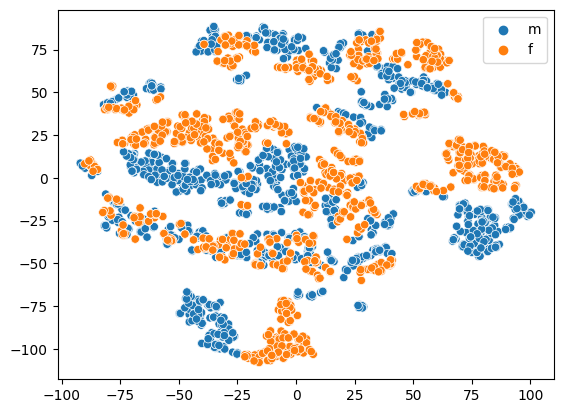

In [109]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, random_state=SEED).fit_transform(hidden_states.cpu().numpy())

sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=(['m'] * 2048 + ['f'] * 2048))

In [64]:
torch.save(hidden_states.cpu(), 'hidden-states-bert.pt')

In [ ]:
# 1. get hidden states from IIT-EEC train set
# 2. run INLP algorithm to get project matrix
# 3. re-train classifier head on eec df + projection matrix (can have goal be avg. of counterfactuals) 
# 4. evaluate INLP on EEC dataset + SemEval

In [71]:
import scipy
from typing import List, Dict
from tqdm import tqdm
from inlp import classifier

def get_rowspace_projection(W: np.ndarray) -> np.ndarray:
    """
    :param W: the matrix over its nullspace to project
    :return: the projection matrix over the rowspace
    """

    if np.allclose(W, 0):
        w_basis = np.zeros_like(W.T)
    else:
        w_basis = scipy.linalg.orth(W.T) # orthogonal basis

    P_W = w_basis.dot(w_basis.T) # orthogonal projection on W's rowspace

    return P_W

def get_projection_to_intersection_of_nullspaces(rowspace_projection_matrices: List[np.ndarray], input_dim: int):
    """
    Given a list of rowspace projection matrices P_R(w_1), ..., P_R(w_n),
    this function calculates the projection to the intersection of all nullspasces of the matrices w_1, ..., w_n.
    uses the intersection-projection formula of Ben-Israel 2013 http://benisrael.net/BEN-ISRAEL-NOV-30-13.pdf:
    N(w1)∩ N(w2) ∩ ... ∩ N(wn) = N(P_R(w1) + P_R(w2) + ... + P_R(wn))
    :param rowspace_projection_matrices: List[np.array], a list of rowspace projections
    :param dim: input dim
    """

    I = np.eye(input_dim)
    Q = np.sum(rowspace_projection_matrices, axis = 0)
    P = I - get_rowspace_projection(Q)

    return P

def debias_by_specific_directions(directions: List[np.ndarray], input_dim: int):
    """
    the goal of this function is to perform INLP on a set of user-provided directiosn (instead of learning those directions).
    :param directions: list of vectors, as numpy arrays.
    :param input_dim: dimensionality of the vectors.
    """

    rowspace_projections = []

    for v in directions:
        P_v = get_rowspace_projection(v)
        rowspace_projections.append(P_v)

    P = get_projection_to_intersection_of_nullspaces(rowspace_projections, input_dim)

    return P

def get_debiasing_projection(classifier_class, cls_params: Dict, num_classifiers: int, input_dim: int,
                             is_autoregressive: bool,
                             min_accuracy: float, X_train: np.ndarray, Y_train: np.ndarray, X_dev: np.ndarray,
                             Y_dev: np.ndarray, by_class=False, Y_train_main=None,
                             Y_dev_main=None, dropout_rate = 0) -> np.ndarray:
    """
    :param classifier_class: the sklearn classifier class (SVM/Perceptron etc.)
    :param cls_params: a dictionary, containing the params for the sklearn classifier
    :param num_classifiers: number of iterations (equivalent to number of dimensions to remove)
    :param input_dim: size of input vectors
    :param is_autoregressive: whether to train the ith classiifer on the data projected to the nullsapces of w1,...,wi-1
    :param min_accuracy: above this threshold, ignore the learned classifier
    :param X_train: ndarray, training vectors
    :param Y_train: ndarray, training labels (protected attributes)
    :param X_dev: ndarray, eval vectors
    :param Y_dev: ndarray, eval labels (protected attributes)
    :param by_class: if true, at each iteration sample one main-task label, and extract the protected attribute only from vectors from this class
    :param T_train_main: ndarray, main-task train labels
    :param Y_dev_main: ndarray, main-task eval labels
    :param dropout_rate: float, default: 0 (note: not recommended to be used with autoregressive=True)
    :return: P, the debiasing projection; rowspace_projections, the list of all rowspace projection; Ws, the list of all calssifiers.
    """
    if dropout_rate > 0 and is_autoregressive:
        print("Note: when using dropout with autoregressive training, the property w_i.dot(w_(i+1)) = 0 no longer holds.")

    I = np.eye(input_dim)

    if by_class:
        if ((Y_train_main is None) or (Y_dev_main is None)):
            raise Exception("Need main-task labels for by-class training.")
        main_task_labels = list(set(Y_train_main.tolist()))

    X_train_cp = X_train.copy()
    X_dev_cp = X_dev.copy()
    rowspace_projections = []
    Ws = []

    pbar = tqdm(range(num_classifiers))
    for i in pbar:

        clf = classifier.SKlearnClassifier(classifier_class(**cls_params))
        dropout_scale = 1./(1 - dropout_rate + 1e-6)
        dropout_mask = (np.random.rand(*X_train.shape) < (1-dropout_rate)).astype(float) * dropout_scale


        if by_class:
            #cls = np.random.choice(Y_train_main)  # uncomment for frequency-based sampling
            cls = random.choice(main_task_labels)
            relevant_idx_train = Y_train_main == cls
            relevant_idx_dev = Y_dev_main == cls
        else:
            relevant_idx_train = np.ones(X_train_cp.shape[0], dtype=bool)
            relevant_idx_dev = np.ones(X_dev_cp.shape[0], dtype=bool)

        acc = clf.train_network((X_train_cp * dropout_mask)[relevant_idx_train], Y_train[relevant_idx_train], X_dev_cp[relevant_idx_dev], Y_dev[relevant_idx_dev])
        pbar.set_description("iteration: {}, accuracy: {}".format(i, acc))
        if acc < min_accuracy: continue

        W = clf.get_weights()
        Ws.append(W)
        P_rowspace_wi = get_rowspace_projection(W) # projection to W's rowspace
        rowspace_projections.append(P_rowspace_wi)

        if is_autoregressive:

            """
            to ensure numerical stability, explicitly project to the intersection of the nullspaces found so far (instaed of doing X = P_iX,
            which is problematic when w_i is not exactly orthogonal to w_i-1,...,w1, due to e.g inexact argmin calculation).
            """
            # use the intersection-projection formula of Ben-Israel 2013 http://benisrael.net/BEN-ISRAEL-NOV-30-13.pdf:
            # N(w1)∩ N(w2) ∩ ... ∩ N(wn) = N(P_R(w1) + P_R(w2) + ... + P_R(wn))

            P = get_projection_to_intersection_of_nullspaces(rowspace_projections, input_dim)
            # project

            X_train_cp = (P.dot(X_train.T)).T
            X_dev_cp = (P.dot(X_dev.T)).T

    """
    calculae final projection matrix P=PnPn-1....P2P1
    since w_i.dot(w_i-1) = 0, P2P1 = I - P1 - P2 (proof in the paper); this is more stable.
    by induction, PnPn-1....P2P1 = I - (P1+..+PN). We will use instead Ben-Israel's formula to increase stability and also generalize to the non-orthogonal case (e.g. with dropout),
    i.e., we explicitly project to intersection of all nullspaces (this is not critical at this point; I-(P1+...+PN) is roughly as accurate as this provided no dropout & regularization)
    """

    P = get_projection_to_intersection_of_nullspaces(rowspace_projections, input_dim)

    return P, rowspace_projections, Ws

In [68]:
from sklearn.linear_model import SGDClassifier

num_classifiers = 200
classifier_class = SGDClassifier #Perceptron
input_dim = hidden_states.size(-1)
is_autoregressive = True
min_accuracy = 0.0

In [69]:
X = hidden_states.cpu().numpy()
Y = np.array([0] * 2048 + [1] * 2048)

In [72]:
P, rowspace_projections, Ws = get_debiasing_projection(classifier_class, {}, num_classifiers, input_dim, is_autoregressive, min_accuracy, X, Y, X, Y, by_class = False)

iteration: 199, accuracy: 0.510009765625: 100%|██████████| 200/200 [10:36<00:00,  3.18s/it]


In [90]:
for p in LIM_trainer.model.classifier_layer.parameters():
    p.requires_grad = True

In [106]:
X_train_INLP = torch.mm(torch.tensor(X, dtype=torch.float), torch.tensor(P, dtype=torch.float))
Y_train_INLP = y_base_train

c:\Users\amirz\.conda\envs\interchange\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\amirz\.conda\envs\interchange\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot: >

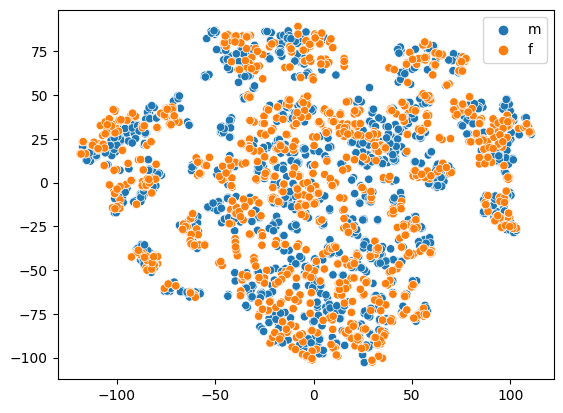

In [111]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, random_state=SEED).fit_transform(X_train_INLP.cpu().numpy())

sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=(['m'] * 2048 + ['f'] * 2048))

In [108]:
from tqdm import trange

n_epochs = 5
batch_size = 8

optimizer = LIM_trainer.build_optimizer()
loss = torch.nn.MSELoss(reduction='mean')

optimizer.zero_grad()
for iteration in range(n_epochs):
    epoch_error = 0
    with trange(0, X_train_INLP.size(0), batch_size) as pbar:
        for b in pbar:
            batch = X_train_INLP[b: b + batch_size].to(LIM_trainer.device)
            batch_labels = Y_train_INLP[b: b + batch_size].to(LIM_trainer.device)

            batch_preds = LIM_trainer.model.classifier_layer(batch)
            err = loss(batch_preds.squeeze(), batch_labels.to(torch.float).squeeze())
            err.backward()

            epoch_error += err.item()
            pbar.set_postfix({'loss': err.item(), 'epoch_loss': epoch_error})

            optimizer.step()
            optimizer.zero_grad()

100%|██████████| 512/512 [00:03<00:00, 154.94it/s, loss=0.00278, epoch_loss=178]


In [110]:
torch.save(LIM_trainer.model.state_dict(), 'bert-inlp.pt')

In [112]:
eec_dataset = get_EEC_dataset('bert-base-uncased')

In [132]:
def predict_with_inlp(X_base):
    proj_mat = torch.tensor(P, dtype=torch.float).to(LIM_trainer.device)

    hidden_states = get_hidden_activations(X_base)

    projected_states = torch.mm(hidden_states, proj_mat)

    return LIM_trainer.model.classifier_layer(projected_states).squeeze()

In [133]:
def evaluate_on_EEC_INLP(LIM_trainer, dataset):
    pronoun_dataset_m, proper_noun_dataset_m, pronoun_dataset_f, proper_noun_dataset_f = dataset
    
    predictions_m = predict_with_inlp(pronoun_dataset_m)
    predictions_f = predict_with_inlp(pronoun_dataset_f)

    for x_m in zip(*proper_noun_dataset_m):
        predictions_m = torch.cat((
            predictions_m,
            predict_with_inlp(x_m).mean().unsqueeze(0)
        ))
    
    for x_f in zip(*proper_noun_dataset_f):
        predictions_f = torch.cat((
            predictions_f,
            predict_with_inlp(x_f).mean().unsqueeze(0)
        ))
    
    return predictions_m, predictions_f

In [134]:
predictions_m, predictions_f = evaluate_on_EEC_INLP(LIM_trainer, eec_dataset)
predictions_m = predictions_m.detach().cpu().numpy()
predictions_f = predictions_f.detach().cpu().numpy()

In [137]:
print(predictions_m.mean(), predictions_f.mean())
print(predictions_m.mean() - predictions_f.mean())

0.5695887 0.5613797
0.00820905


In [138]:
print((predictions_m > predictions_f).sum() / len(predictions_m))

0.585081585081585


In [139]:
from scipy.stats import ttest_ind

ttest_ind(predictions_m, predictions_f)

Ttest_indResult(statistic=1.236429011350224, pvalue=0.21663827942246694)

In [142]:
from scipy.stats import pearsonr

X_semeval_test, y_semeval_test = get_semeval_dataset(test_df, 'bert-base-uncased', test_df.shape[0] - 1)
predictions = predict_with_inlp(
    X_semeval_test
)

pearsonr(predictions.detach().cpu().numpy(), y_semeval_test.numpy())

PearsonRResult(statistic=0.28042215153462713, pvalue=2.137503194022302e-21)

## Debiasing CLIP?

In [1]:
import pandas as pd
import numpy as np
import itertools
import random
from functools import reduce
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import torch
import json


CONCADIA_PATH = 'C:/Users/amirz/Source/NLP/local/concadia/concadia.pt' 
CONCADIA_METADATA_PATH = 'C:/Users/amirz/Source/NLP/local/concadia/wiki_split.json'
COLUMNS = ['filename', 'caption', 'description', 'image_features']

SEED = 42
VAR = 0

random.seed(SEED)

class IITConcadiaDataset:
    def __init__(self, embed_func, split):
        self.embed_func = embed_func
        self.split = split
        concadia_data = torch.load(CONCADIA_PATH, map_location='cpu')
        concadia_df = pd.DataFrame(concadia_data, columns=COLUMNS).set_index('filename')
        with open(CONCADIA_METADATA_PATH) as f:
            concadia_metadata = json.load(f)['images']
        train_filenames = [im_data['filename'] for im_data in concadia_metadata if im_data['split'] == 'train']
        val_filenames = [im_data['filename'] for im_data in concadia_metadata if im_data['split'] == 'val']
        test_filenames = [im_data['filename'] for im_data in concadia_metadata if im_data['split'] == 'test']
        self.train_df = concadia_df.loc[train_filenames]
        self.val_df = concadia_df.loc[val_filenames]
        self.test_df = concadia_df.loc[test_filenames]

        if split == 'train':
            self.concadia_df = self.train_df
        elif split == 'val':
            self.concadia_df = self.val_df
        else:
            self.concadia_df = self.test_df

    def get_intervention(self, base, source):
        return VAR

    def create_dataset(self, shuffle=True):
        data = []
        for i, row in self.concadia_df.iterrows():
            image_embeds = row['image_features']
            base, source = row['caption'], row['description']
            base_x, base_mask = self.embed_func(base)
            source_x, source_mask = self.embed_func(source)
            base_label = 0   # base label ignored during training
            intervention = self.get_intervention(base, source)
            IIT_label = 1    # 0 - prefer base input; 1 - prefer intervened input
            data.append((base_x, base_mask, base_label, source_x, source_mask, IIT_label, intervention, image_embeds))

            # repeat but with swapped base and source
            base, source = source, base
            base_x, base_mask = self.embed_func(base)
            source_x, source_mask = self.embed_func(source)
            base_label = 0
            intervention = self.get_intervention(base, source)
            IIT_label = 0   # 0 - prefer base input; 1 - prefer intervened input
            data.append((base_x, base_mask, base_label, source_x, source_mask, IIT_label, intervention, image_embeds))

        if shuffle:
            data.sort(key=lambda x: x[-2])
            random.shuffle(data)

        base, base_mask, y, source, source_mask, IIT_y, interventions, image_embeds = zip(*data)
        self.base = base
        self.base_mask = base_mask
        self.source = source
        self.source_mask = source_mask
        self.y = np.array(y)
        self.IIT_y = np.array(IIT_y)
        self.interventions = np.array(interventions)
        self.image_embeds = image_embeds
        return (
            (self.base, self.base_mask, self.image_embeds), 
            self.y, 
            [(self.source,self.source_mask, self.image_embeds)], 
            self.IIT_y, 
            self.interventions
        )

c:\Users\amirz\.conda\envs\interchange\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_IIT_concadia_dataset(
    tokenizer_name,
    split="train",
    shuffle=True
):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def encoding(X):
        input = [X]
        data = tokenizer(
            input,
            max_length=77,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        indices = data['input_ids']
        mask = data['attention_mask']
        return (indices, mask)
    
    dataset = IITConcadiaDataset(
        embed_func=encoding,
        split=split
    )
    
    X_base, y_base, X_sources,  y_IIT, interventions = dataset.create_dataset(shuffle=shuffle)
    y_base = torch.tensor(y_base)
    y_IIT = torch.tensor(y_IIT)
    interventions = torch.tensor(interventions)
    return X_base, y_base, X_sources, y_IIT, interventions

In [3]:
from transformers import AutoTokenizer, CLIPModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

In [4]:
from LIM_clip import LIMClipTextModel

iit_layer = 10
hidden_dim_per_concept = 128
model_dim = 128

intervention_ids_to_coords = {
    VAR: [{"layer":iit_layer, "start":0, "end":hidden_dim_per_concept}]
}

lim_clip = LIMClipTextModel(
    clip, 
    max_length=77, 
    device=device, 
    target_layers=[iit_layer], 
    target_dims={ "start": 0, "end": model_dim },
    # learn_intervention_dim=hidden_dim_per_concept
)

In [5]:
lim_clip.set_analysis_mode(False)

In [5]:
lim_clip.load_state_dict(torch.load('clip_iit.pt'))

<All keys matched successfully>

In [7]:
from trainer import CLIPLIMTrainer

training_parameters={
    'warm_start': False, 
    'max_iter': 2, 
    'batch_size': 6,
    'n_iter_no_change': 10, 
    'shuffle_train': False, 
    'eta': 1e-5,
    'device': device        
}

clip_trainer = CLIPLIMTrainer(
    lim_clip,
    **training_parameters
)

In [6]:
train_datasetIIT = get_IIT_concadia_dataset(
    split="train",
    tokenizer_name='openai/clip-vit-base-patch32'
)
X_base_train, y_base_train = train_datasetIIT[0:2]
iit_data = tuple(train_datasetIIT[2:])

In [8]:
_ = clip_trainer.fit(
    X_base_train, 
    y_base_train, 
    iit_data=iit_data,
    intervention_ids_to_coords=intervention_ids_to_coords
)

Epoch 2: 100%|██████████| 25845/25845 [4:30:22<00:00,  1.59it/s, loss=0.173, epoch_loss=2.28e+3]         
Finished epoch 2 of 2; error is 2278.631408380883

In [9]:
torch.save(clip_trainer.model.state_dict(), 'clip_iit_on_train.pt')

### Evaluate IIT

In [10]:
# evaluate on train set
X_sources_train, y_IIT_train, intervention_train = iit_data

IIT_preds_train = clip_trainer.iit_predict(
    X_base_train, X_sources_train, 
    intervention_train, 
    intervention_ids_to_coords
)

100%|██████████| 25845/25845 [28:09<00:00, 15.30it/s]


In [11]:
base_preds_train = clip_trainer.predict(
    X_base_train
)

100%|██████████| 25845/25845 [13:23<00:00, 32.17it/s]


In [12]:
y_pred_train = torch.stack((base_preds_train, IIT_preds_train)).argmax(dim=0)
y_pred_train.shape

torch.Size([155068])

In [13]:
from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(
    y_pred=y_pred_train.squeeze().detach().cpu().numpy(), 
    y_true=y_IIT_train.squeeze().detach().cpu().numpy()
)
f1 = f1_score(
    y_pred=y_pred_train.squeeze().detach().cpu().numpy(), 
    y_true=y_IIT_train.squeeze().detach().cpu().numpy()
)

print('Train')
print(acc)
print(f1)

Train
0.9464041581757681
0.9435282766305862


In [14]:
val_datasetIIT = get_IIT_concadia_dataset(
    split="test",
    tokenizer_name='openai/clip-vit-base-patch32'
)
X_base_val, y_base_val = val_datasetIIT[0:2]
iit_data_val = tuple(val_datasetIIT[2:])

In [15]:
# evaluate on eval set
X_sources_val, y_IIT_val, intervention_val = iit_data_val

n_samples = y_IIT_val.size(0)
batch_size = training_parameters['batch_size']

IIT_preds_val = clip_trainer.iit_predict(
    X_base_val, 
    X_sources_val, 
    intervention_val, 
    intervention_ids_to_coords
)

100%|██████████| 3231/3231 [03:00<00:00, 17.91it/s]


In [16]:
base_preds_val = clip_trainer.predict(
    X_base_val
)

100%|██████████| 3231/3231 [01:42<00:00, 31.51it/s]


In [17]:
y_pred_val = torch.stack((base_preds_val, IIT_preds_val)).argmax(dim=0)
y_pred_val.shape

torch.Size([19382])

In [18]:
from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(
    y_pred=y_pred_val.squeeze().detach().cpu().numpy(), 
    y_true=y_IIT_val.squeeze().detach().cpu().numpy()
)
f1 = f1_score(
    y_pred=y_pred_val.squeeze().detach().cpu().numpy(), 
    y_true=y_IIT_val.squeeze().detach().cpu().numpy()
)

print('Val')
print(acc)
print(f1)

Val
0.8940253843772572
0.8933319484835895


### Evaluate "Bias"

In [19]:
val_datasetIIT = get_IIT_concadia_dataset(
    split="val",
    tokenizer_name='openai/clip-vit-base-patch32',
    shuffle=False
)
X_base_val, y_base_val = val_datasetIIT[0:2]
iit_data_val = tuple(val_datasetIIT[2:])

In [20]:
base_preds_val = clip_trainer.predict(
    X_base_val
)

100%|██████████| 3231/3231 [02:00<00:00, 26.92it/s]


In [21]:
# make pairwise comparison between captions and descriptions
base_preds_val = base_preds_val.view((-1, 2))
base_preds_val.shape

torch.Size([9693, 2])

<AxesSubplot: ylabel='count'>

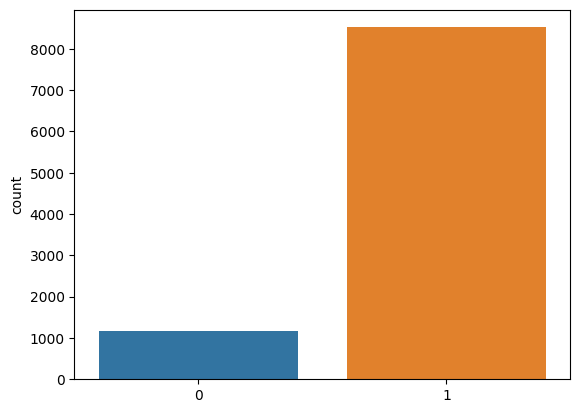

In [22]:
import seaborn as sns

y_preds_val = base_preds_val.argmax(dim=-1).detach().cpu().numpy()

sns.countplot(x=y_preds_val)

In [23]:
y_preds_val.mean()

0.8788816671825028

## Evaluate on CIFAR-100

In [24]:
from torchvision.datasets import CIFAR100
import os

cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

Files already downloaded and verified


In [2]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
processed = processor(images=[im for im, _ in cifar100], return_tensors='pt')

In [ ]:
processed['pixel_values'].shape

torch.Size([10000, 3, 224, 224])

In [26]:
from tqdm import trange

batch_size = 8

outputs = None
with torch.no_grad():
    for b in trange(0, processed['pixel_values'].size(0), batch_size):
        batch = processed['pixel_values'][b: b + batch_size].to(device)
        image_features = model.get_image_features(pixel_values=batch)
        if outputs is None:
            outputs = image_features
        else:
            outputs = torch.cat((outputs, image_features))

100%|██████████| 1250/1250 [00:45<00:00, 27.64it/s]


In [11]:
torch.save(outputs, 'cifar100-image-encoding.pt')

In [25]:
import os
from torchvision.datasets import CIFAR100

class CIFAR100Dataset:
    def __init__(self, embed_func):
        self.embed_func = embed_func
        self.cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

    def create_dataset(self):
        data = []
        for class_label in self.cifar100.classes:
            base = f'a photo of a {class_label}'
            base_x, base_mask = self.embed_func(base)
            base_label = 0   # base label ignored during training
            data.append((base_x, base_mask, base_label))

        base, base_mask, y = zip(*data)
        self.base = base
        self.base_mask = base_mask
        self.y = np.array(y)
        return (
            (self.base, self.base_mask), 
            self.y
        )

In [26]:
def get_cifar_100_dataset(
    tokenizer_name
):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def encoding(X):
        input = [X]
        data = tokenizer(
            input,
            max_length=77,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        indices = data['input_ids']
        mask = data['attention_mask']
        return (indices, mask)
    
    dataset = CIFAR100Dataset(
        embed_func=encoding
    )
    
    X_base, y_base = dataset.create_dataset()
    y_base = torch.tensor(y_base)
    return X_base, y_base

In [27]:
X_base, y_base = get_cifar_100_dataset('openai/clip-vit-base-patch32')

Files already downloaded and verified


In [28]:
input, mask = X_base
input = torch.stack(input).to(device).squeeze()
mask = torch.stack(mask).to(device).squeeze()

with torch.no_grad():
    text_embeds = clip_trainer.model.get_text_encodings((input, mask))

In [29]:
image_embeds = torch.load('cifar100-image-encoding.pt')

In [30]:
image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

In [31]:
logits_per_text = torch.matmul(text_embeds, image_embeds.squeeze(1).t())

In [32]:
logits_per_image = logits_per_text.t()

In [33]:
labels = [l for _, l in cifar100]

In [34]:
from sklearn.metrics import f1_score

preds = logits_per_image.argmax(dim=-1).detach().cpu().numpy()

f1_score(y_true=labels, y_pred=preds, average='macro')

0.2254913437738646

Evaluate original CLIP

In [6]:
text_inputs = processor(text=[f"a photo of a {c}" for c in cifar100.classes], return_tensors='pt', padding=True) 
text_inputs = { k: v.to(device) for k, v in text_inputs.items() }

In [7]:
text_embeds = model.get_text_features(**text_inputs)

In [9]:
image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

logits_per_text = torch.matmul(text_embeds, image_embeds.squeeze(1).t())
logits_per_image = logits_per_text.t()

In [11]:
labels = [l for _, l in cifar100]

In [12]:
from sklearn.metrics import f1_score

preds = logits_per_image.argmax(dim=-1).detach().cpu().numpy()

f1_score(y_true=labels, y_pred=preds, average='macro')

0.6148434147736954

## Compare to Human Evaluations

In [1]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

c:\Users\amirz\.conda\envs\interchange\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd

cosid_path = 'C:/Users/amirz/Source/NLP/clones/contextual-description-evaluation/metrics/clipscore/results/cosid-clipscores.csv'
cosid_df = pd.read_csv(cosid_path)

In [3]:
import os

image_path = 'C:/Users/amirz/Source/NLP/clones/contextual-description-evaluation/metrics/clipscore/cosid_data/cosid_images'

image_filenames = [fn for fn in os.listdir(image_path) if not fn.startswith('.')]

image_to_filename = {
    fn[:fn.rfind('.')] : fn
    for fn in image_filenames
}

In [4]:
shortcut = {
    '1600px-2019-11-28_14_40_55_A_dinner_table_laid_out_for_Thanksgiving_Dinner_in_the_Parkway_Village_section_of_Ewing_Township,_Mercer_County,_New_Jersey_version1': '1.jpg',
    '1600px-2019-11-28_14_40_55_A_dinner_table_laid_out_for_Thanksgiving_Dinner_in_the_Parkway_Village_section_of_Ewing_Township,_Mercer_County,_New_Jersey_version2': '2.jpg',
    '1600px-2019-11-28_14_40_55_A_dinner_table_laid_out_for_Thanksgiving_Dinner_in_the_Parkway_Village_section_of_Ewing_Township,_Mercer_County,_New_Jersey_version3': '3.jpg'
}

image_to_filename.update(shortcut)

In [5]:
cosid_df.columns

Index(['imgstem_version', 'texts', 'text_controls', 'clipscore'], dtype='object')

In [6]:
from PIL import Image

images = [
    Image.open(os.path.join(image_path, image_to_filename[filename]))
    for filename in cosid_df['imgstem_version']
]

image_inputs = processor(images=images, return_tensors='pt')
image_inputs = {k: v.to(device) for k, v in image_inputs.items()}

In [7]:
from tqdm import trange

batch_size = 8

image_embeds = None
with torch.no_grad():
    for b in trange(0, image_inputs['pixel_values'].size(0), batch_size):
        batch = image_inputs['pixel_values'][b: b + batch_size].to(device)
        image_features = model.get_image_features(pixel_values=batch)
        if image_embeds is None:
            image_embeds = image_features
        else:
            image_embeds = torch.cat((image_embeds, image_features))

100%|██████████| 9/9 [00:05<00:00,  1.50it/s]


In [8]:
COSID_PATH = 'C:/Users/amirz/Source/NLP/clones/contextual-description-evaluation/metrics/clipscore/results/cosid-clipscores.csv'

class ContextDescriptionDataset:
    def __init__(self, embed_func):
        self.embed_func = embed_func
        self.cosid_df = pd.read_csv(COSID_PATH)

    def create_dataset(self):
        data = []
        for text in self.cosid_df['texts'].values:
            base_x, base_mask = self.embed_func(text)
            base_label = 0   # base label ignored
            data.append((base_x, base_mask, base_label))

        base, base_mask, y = zip(*data)
        self.base = base
        self.base_mask = base_mask
        self.y = np.array(y)
        return (
            (self.base, self.base_mask), 
            self.y
        )

In [9]:
def get_context_descriptions_dataset(
    tokenizer_name
):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def encoding(X):
        input = [X]
        data = tokenizer(
            input,
            max_length=77,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        indices = data['input_ids']
        mask = data['attention_mask']
        return (indices, mask)
    
    dataset = ContextDescriptionDataset(
        embed_func=encoding
    )
    
    X_base, y_base = dataset.create_dataset()
    y_base = torch.tensor(y_base)
    return X_base, y_base

In [17]:
X_base, y_base = get_context_descriptions_dataset('openai/clip-vit-base-patch32')

input, mask = X_base
input = torch.stack(input).to(device).squeeze()
mask = torch.stack(mask).to(device).squeeze()

with torch.no_grad():
    text_embeds = clip_trainer.model.get_text_encodings((input, mask))

In [18]:
image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

In [19]:
logits = torch.sum(image_embeds * text_embeds, axis=1)
logits.shape

torch.Size([70])

In [20]:
cosid_df['clipscore_iit'] = logits.cpu().numpy() * 2.5

In [21]:
cosid_df.to_csv('cosid-clipscores-finetuned.csv')

## Compare to Finetuning

In [1]:
import pandas as pd
import numpy as np
import itertools
import random
from functools import reduce
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import torch
import json


CONCADIA_PATH = 'C:/Users/amirz/Source/NLP/local/concadia/concadia.pt' 
CONCADIA_METADATA_PATH = 'C:/Users/amirz/Source/NLP/local/concadia/wiki_split.json'
COLUMNS = ['filename', 'caption', 'description', 'image_features']

SEED = 42
VAR = 0

random.seed(SEED)

class ConcadiaDataset:
    def __init__(self, embed_func, split):
        self.embed_func = embed_func
        self.split = split
        concadia_data = torch.load(CONCADIA_PATH, map_location='cpu')
        concadia_df = pd.DataFrame(concadia_data, columns=COLUMNS).set_index('filename')
        with open(CONCADIA_METADATA_PATH) as f:
            concadia_metadata = json.load(f)['images']
        train_filenames = [im_data['filename'] for im_data in concadia_metadata if im_data['split'] == 'train']
        val_filenames = [im_data['filename'] for im_data in concadia_metadata if im_data['split'] == 'val']
        test_filenames = [im_data['filename'] for im_data in concadia_metadata if im_data['split'] == 'test']
        self.train_df = concadia_df.loc[train_filenames]
        self.val_df = concadia_df.loc[val_filenames]
        self.test_df = concadia_df.loc[test_filenames]

        if split == 'train':
            self.concadia_df = self.train_df
        elif split == 'val':
            self.concadia_df = self.val_df
        else:
            self.concadia_df = self.test_df

    def create_dataset(self, shuffle=False):
        data = []
        for i, row in self.concadia_df.iterrows():
            image_embeds = row['image_features']
            caption, description = row['caption'], row['description']
            base_x, base_mask = self.embed_func(caption)
            base_label = 1   # base label ignored during training
            data.append((base_x, base_mask, base_label, image_embeds))

            base_x, base_mask = self.embed_func(description)
            base_label = 0   # base label ignored during training
            data.append((base_x, base_mask, base_label, image_embeds))

        if shuffle:
            random.shuffle(data)
        
        base, base_mask, y, image_embeds = zip(*data)
        self.base = base
        self.base_mask = base_mask
        self.y = np.array(y)
        self.image_embeds = image_embeds
        return (
            (self.base, self.base_mask, self.image_embeds), 
            self.y
        )

c:\Users\amirz\.conda\envs\interchange\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_concadia_dataset(
    tokenizer_name,
    split="train",
    shuffle=False
):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def encoding(X):
        input = [X]
        data = tokenizer(
            input,
            max_length=77,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        indices = data['input_ids']
        mask = data['attention_mask']
        return (indices, mask)
    
    dataset = ConcadiaDataset(
        embed_func=encoding,
        split=split
    )
    
    X_base, y_base = dataset.create_dataset(shuffle=shuffle)
    y_base = torch.tensor(y_base)
    return X_base, y_base

In [3]:
from transformers import AutoTokenizer, CLIPModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

In [4]:
from LIM_clip import LIMClipTextModel

iit_layer = 10
hidden_dim_per_concept = 128

intervention_ids_to_coords = {
    VAR: [{"layer":iit_layer, "start":0, "end":hidden_dim_per_concept}]
}

lim_clip = LIMClipTextModel(
    clip, 
    max_length=77, 
    device=device, 
    target_layers=[iit_layer], 
    target_dims={ "start": 0, "end": hidden_dim_per_concept },
    # learn_intervention_dim=hidden_dim_per_concept
)

In [5]:
lim_clip.set_analysis_mode(False)

In [6]:
# lim_clip.load_state_dict(torch.load('clip_finetuned.pt'))

In [7]:
from trainer import CLIPLIMTrainer

training_parameters={
    'warm_start': False, 
    'max_iter': 2, 
    'batch_size': 12,
    # 'n_iter_no_change': 10, 
    'shuffle_train': False, 
    'eta': 1e-5,
    'device': device        
}

clip_trainer = CLIPLIMTrainer(
    lim_clip,
    **training_parameters
)

In [8]:
train_dataset = get_concadia_dataset(
    split="test",
    tokenizer_name='openai/clip-vit-base-patch32',
    shuffle=False
)
X_base_train, y_base_train = train_dataset

In [9]:
_ = clip_trainer.fit(
    X_base_train, 
    y_base_train, 
    intervention_ids_to_coords=intervention_ids_to_coords
)

Epoch 2: 100%|██████████| 1616/1616 [04:45<00:00,  5.67it/s, loss=0.000827, epoch_loss=139] 
Finished epoch 2 of 2; error is 138.6899815192433

In [10]:
torch.save(clip_trainer.model.state_dict(), 'clip_finetuned.pt')

### Evaluate IIT

In [11]:
base_preds_train = clip_trainer.predict(
    X_base_train
)
y_train = y_base_train.view(-1, 2)[:, 0]
preds_train = base_preds_train.view(-1, 2).argmax(dim=-1)

100%|██████████| 1616/1616 [01:18<00:00, 20.50it/s]


In [12]:
from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(
    y_pred=preds_train.squeeze().detach().cpu().numpy(), 
    y_true=y_train.squeeze().detach().cpu().numpy()
)
f1 = f1_score(
    y_pred=preds_train.squeeze().detach().cpu().numpy(), 
    y_true=y_train.squeeze().detach().cpu().numpy()
)

print('Train')
print(acc)
print(f1)

Train
0.9754411309462387
0.9875679063936481


In [13]:
val_dataset = get_concadia_dataset(
    split="val",
    tokenizer_name='openai/clip-vit-base-patch32',
    shuffle=False
)
X_base_val, y_base_val = val_dataset

In [14]:
base_preds_val = clip_trainer.predict(
    X_base_val
)
y_val = y_base_val.view(-1, 2)[:, 0]
preds_val = base_preds_val.view(-1, 2).argmax(dim=-1)

100%|██████████| 1616/1616 [01:19<00:00, 20.32it/s]


In [15]:
from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(
    y_pred=preds_val.squeeze().detach().cpu().numpy(), 
    y_true=y_val.squeeze().detach().cpu().numpy()
)
f1 = f1_score(
    y_pred=preds_val.squeeze().detach().cpu().numpy(), 
    y_true=y_val.squeeze().detach().cpu().numpy()
)

print('Val')
print(acc)
print(f1)

Val
0.889817393995667
0.9416966917785784
